In [13]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16 # tensorflow_vgg文件夹需要放在脚本当前目录下  
from tensorflow_vgg import utils 

"""加载文件目录"""
data_dir = r'E:\USTC\AI+UAV\作业\第八周\flower_photos'
contents = os.listdir(data_dir)
classes = [each for each in contents if os.path.isdir(data_dir + '/'+each)]    # 读出文件夹中所有花的类别

In [ ]:
"""将数据穿过vgg16"""
batch_size = 10
codes_list = []
labels = []   # 保存每一类图片对应的标签
batch = []    # 保存每一类的图片

codes = None

with tf.Session() as sess:
    vgg = vgg16.Vgg16() 
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])    # vgg的输入数据格式是244 * 224 * 3的像素数据
    with tf.name_scope("content_vgg"):
        vgg.build(input_)  # 建立vgg16模型

    """按类别分别计算relu层的输出"""
    for each in classes:
        class_path = data_dir + '/'+each
        files = os.listdir(class_path)         # 读取每一类的图片
        for i, file in enumerate(files, 1):    # enumerate返回索引和元素;第2个参数指定索引起始值
            img = utils.load_image(os.path.join(class_path, file))    # os.path.join连接多个路径，这里获取了每一张图片的路径
            batch.append(img.reshape((1, 224, 224, 3)))               # 导入当前图片
            labels.append(each)                                       # 导入当前标签
            
            if i % batch_size == 0 or i == len(files):    # 每10张图片是一个batch，进行批量处理
                images = np.concatenate(batch)            # 将一个batch的图片连接成一个np数组

                feed_dict = {input_: images}
                codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict) # 将图片传入计算图,输出运行到relu6层(第一个全连接层后的激活层)的结果
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))       # 将所有的计算结果保存到codes中
                
                batch = []    # 准备处理下一个batch的数据
                print('{} images processed'.format(i))

E:\code\python\UAV_homework\week8\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 0s


D:\project\Anaconda3\envs\backup1\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


10 images processed
20 images processed
30 images processed
40 images processed
50 images processed
60 images processed
70 images processed
80 images processed
90 images processed
100 images processed
110 images processed
120 images processed
130 images processed
140 images processed
150 images processed
160 images processed
170 images processed
180 images processed
190 images processed
200 images processed
210 images processed
220 images processed
230 images processed
240 images processed
250 images processed
260 images processed
270 images processed
280 images processed
290 images processed
300 images processed
310 images processed
320 images processed
330 images processed
340 images processed
350 images processed
360 images processed
370 images processed
380 images processed
390 images processed
400 images processed
410 images processed
420 images processed
430 images processed
440 images processed
450 images processed
460 images processed
470 images processed
480 images processed
4

In [ ]:
np.shape(codes)    # vgg所有卷积层的输出，即全连接层的输入，是4096维的特征值

In [4]:
"""将计算的结果写入磁盘文件"""
with open('codes', 'w') as f:
    codes.tofile(f)
    
import csv
with open('labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

In [2]:
"""加载已有的数据"""
import csv

with open('labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader if len(each) > 0]).squeeze()
    
with open('codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(labels), -1))

In [3]:
"""对标签进行one-hot编码"""
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()    # 定义一个转换器，将标签二值化，默认正标签为1，负标签为0
lb.fit(labels)
labels_vecs = lb.transform(labels) # 执行变换

In [4]:
"""样本分割"""
from sklearn.model_selection import StratifiedShuffleSplit

""" StratifiedShuffleSplit(n_splits=10,test_size=None,train_size=None, random_state=None) """
""" n_splits是将训练数据分成train/test对的组数,默认为10 """
""" test_size和train_size是设置train/test对中train和test所占的比例 """
""" random_state是将样本随机打乱 """
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)    # 定义一个分割器，分割的是索引值

"""按比例对索引值进行分割"""
train_idx, val_idx = next(ss.split(codes, labels))        # next函数返回可迭代对象的的下一个条目
half_val_len = int(len(val_idx)/2)                  
val_idx, test_idx = val_idx[:half_val_len], val_idx[half_val_len:]    # 测试数据分出一半为验证集，一半为测试集

"""由索引值从样本中提取数据"""
train_x, train_y = codes[train_idx], labels_vecs[train_idx]
val_x, val_y = codes[val_idx], labels_vecs[val_idx]
test_x, test_y = codes[test_idx], labels_vecs[test_idx]

print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)

Train shapes (x, y): (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y): (367, 4096) (367, 5)


In [6]:
"""添加全连接层"""

inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])        # 输入特征的维度为none * 4096
labels_ = tf.placeholder(tf.int64, shape=[None, labels_vecs.shape[1]])    # 输入标签的维度为none * 5

fc = tf.contrib.layers.fully_connected(inputs_, 256)    # 第一层256个节点
    
logits = tf.contrib.layers.fully_connected(fc, labels_vecs.shape[1], activation_fn=None)    # 第二层5个节点(输出层)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
cost = tf.reduce_mean(cross_entropy)    # 损失函数为交叉熵

optimizer = tf.train.AdamOptimizer().minimize(cost)    # 优化器为Adam

predicted = tf.nn.softmax(logits)    # 模型输出
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))   
# tf.argmax返回最大值的索引，第2个参数定义按列比较还是按行比较；
# tf.equal()是对比两个矩阵相同位置的元素，相等就返回True，不等返回False
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [7]:
"""定义一个生成器：每次生成一个batch的训练集数据，大小为batch_size"""
def get_batches(x, y, n_batches=10):
    batch_size = len(x) // n_batches    # 结果向下取整
    
    for i in range(0, n_batches*batch_size, batch_size):
        if i != (n_batches - 1) * batch_size:    # 不是最后一个batch
            X, Y = x[i: i+batch_size], y[i: i+batch_size] 
        else:    # 若为最后一个batch，则读完剩余所有数据
            X, Y = x[i:], y[i:]
            
        yield X, Y   # yield就是return一个值，并且记住这个返回的位置，下次迭代就从这个位置后开始

In [8]:
"""训练模型"""
epochs = 10    # 对应n_batches
iteration = 0
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for x, y in get_batches(train_x, train_y):
            feed = {inputs_: x, labels_: y}
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            print("Epoch: {}/{}".format(e+1, epochs), 
                  "Iteration: {}".format(iteration), 
                  "Training loss: {:.5f}".format(loss))
            iteration += 1
            
            if iteration % 5 == 0:    # 训练集和验证集的比例为5:1
                feed = {inputs_: val_x, labels_: val_y}
                val_acc = sess.run(accuracy, feed_dict=feed)
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Validation Acc: {:.4f}".format(val_acc))
                
    saver.save(sess, r'E:\code\python\UAV_homework\week8\task1_result_vgg16\flowers.ckpt')    # 非中文路径

Epoch: 1/10 Iteration: 0 Training loss: 8.39647
Epoch: 1/10 Iteration: 1 Training loss: 15.83363
Epoch: 1/10 Iteration: 2 Training loss: 10.94413
Epoch: 1/10 Iteration: 3 Training loss: 14.81195
Epoch: 1/10 Iteration: 4 Training loss: 11.79666
Epoch: 0/10 Iteration: 5 Validation Acc: 0.5804
Epoch: 1/10 Iteration: 5 Training loss: 6.71006
Epoch: 1/10 Iteration: 6 Training loss: 4.27656
Epoch: 1/10 Iteration: 7 Training loss: 2.19766
Epoch: 1/10 Iteration: 8 Training loss: 0.89826
Epoch: 1/10 Iteration: 9 Training loss: 1.37226
Epoch: 0/10 Iteration: 10 Validation Acc: 0.6485
Epoch: 2/10 Iteration: 10 Training loss: 1.60783
Epoch: 2/10 Iteration: 11 Training loss: 1.77885
Epoch: 2/10 Iteration: 12 Training loss: 1.69607
Epoch: 2/10 Iteration: 13 Training loss: 0.99091
Epoch: 2/10 Iteration: 14 Training loss: 0.71637
Epoch: 1/10 Iteration: 15 Validation Acc: 0.7520
Epoch: 2/10 Iteration: 15 Training loss: 0.76790
Epoch: 2/10 Iteration: 16 Training loss: 1.01550
Epoch: 2/10 Iteration: 17 T

In [9]:
"""测试模型"""
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(r'E:\code\python\UAV_homework\week8\task1_result_vgg16'))
    
    feed = {inputs_: test_x, labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from E:\code\python\UAV_homework\week8\task1_result\flowers.ckpt
Test accuracy: 0.8747


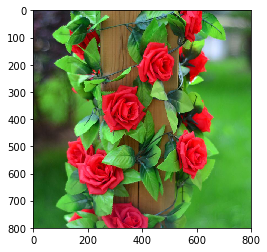

In [12]:
"""读取待预测图片"""
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

test_img_path =r'E:\USTC\AI+UAV\作业\第八周\rose.jpg'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [11]:
"""使用模型进行预测"""
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))

    feed_dict = {input_: img}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(r'E:\code\python\UAV_homework\week8\task1_result_vgg16'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

NameError: name 'utils' is not defined

In [ ]:
"""显示预测结果"""
plt.barh(np.arange(5), prediction)
_ = plt.yticks(np.arange(5), lb.classes_)

In [ ]:
prediction